In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.optim as optim
from torch.nn.functional import mse_loss
from torchvision import transforms, models

## Загрузим модель

In [2]:
vgg = models.vgg19(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad_(False)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
model_description = vgg.to(device)

## Загрузим изображения

In [5]:
def load_image(image_file, shape=None):
    image = Image.open(image_file).convert('RGB')

    size = 300
    if shape is not None:
        size = shape
        
    transform = transforms.Compose([transforms.Resize(size), transforms.ToTensor(), 
                                       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    
    return transform(image)[:3,:,:].unsqueeze(0)

In [6]:
def tensor2numpy(tensor):
    image = tensor.to('cpu').clone().detach().numpy().squeeze().transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    return image.clip(0, 1)

In [7]:
content = load_image('images/new_york.jpg').to(device)
style = load_image('images/boats.jpg', shape=content.shape[-2:]).to(device)

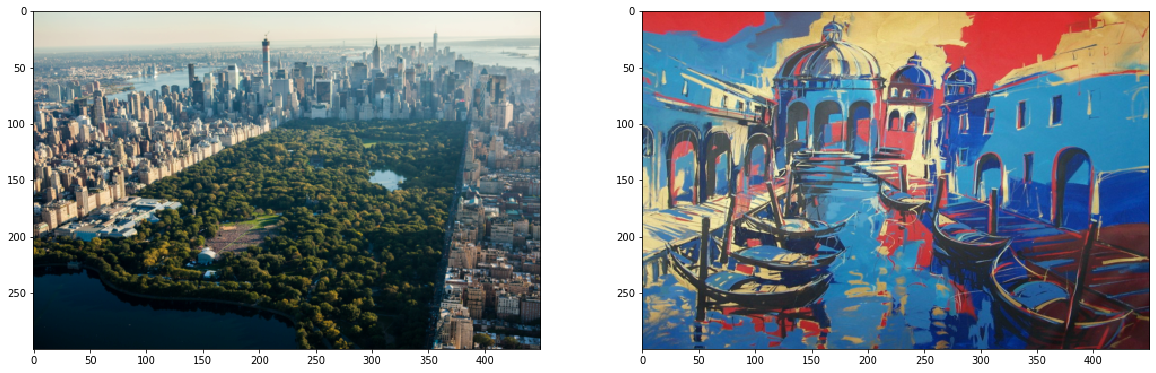

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
ax1.imshow(tensor2numpy(content))
ax2.imshow(tensor2numpy(style))
plt.show()

## Style Transfer

In [9]:
def get_features(image, model):
    layers = {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', 
              '19': 'conv4_1', '21': 'conv4_2', '28': 'conv5_1'}
    
    features = dict()
    for name, layer in model._modules.items():
        image = layer(image)
        if name in layers:
            features[layers[name]] = image
            
    return features

In [10]:
def gram_matrix(tensor):
    tensor = tensor.view(tensor.shape[1], tensor.shape[2] * tensor.shape[3])
    return torch.mm(tensor, tensor.t())

In [11]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [12]:
layers_style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [13]:
style_weights = {'conv1_1': 1., 'conv2_1': 0.75, 'conv3_1': 0.2, 'conv4_1': 0.2, 'conv5_1': 0.2}

In [14]:
content_weight = 1
style_weight = 1e7

In [15]:
target = content.clone().requires_grad_(True).to(device)

## Обновим target

In [16]:
optimizer = optim.Adam([target], lr=0.004)

In [17]:
for i in tqdm(range(2000)):
    target_features = get_features(target, vgg)
    content_loss = mse_loss(target_features['conv4_2'], content_features['conv4_2'])

    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        
        target_gram = gram_matrix(target_feature)
        style_gram = layers_style_grams[layer]
        
        denom = target_feature.shape[1] * target_feature.shape[2] * target_feature.shape[3]
        style_loss += style_weights[layer] * mse_loss(target_gram, style_gram) / denom

    total_loss = content_weight * content_loss + style_weight * style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

## В итоге получили

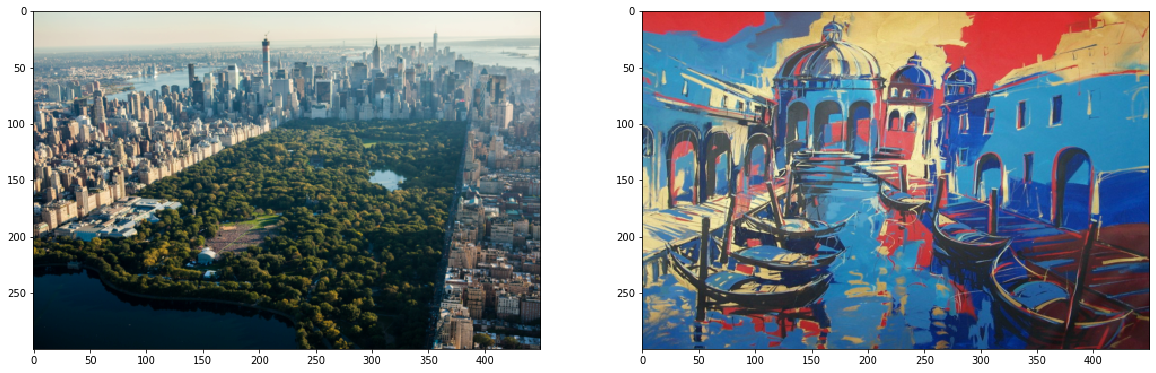

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
ax1.imshow(tensor2numpy(content))
ax2.imshow(tensor2numpy(style))
plt.show()

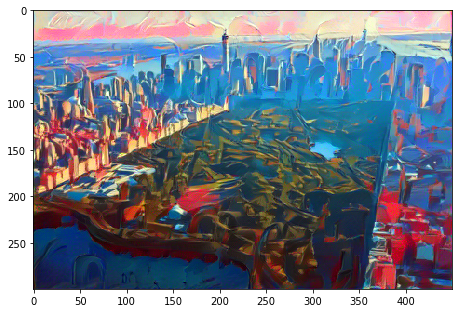

In [19]:
plt.figure(figsize=(7.5, 7.5))
plt.imshow(tensor2numpy(target))
plt.show()